--- Đang tải dữ liệu từ: dataAfterPreprocess.csv ---
Tải dữ liệu thành công.
Đã chuẩn hóa các cột đặc trưng.
Đã lưu cỗ máy chuẩn hóa vào: preprocessor.pkl

--- Đang chạy phương pháp Elbow để tìm K (từ 1 đến 10)... ---
Đã xong! Đang hiển thị đồ thị Elbow...


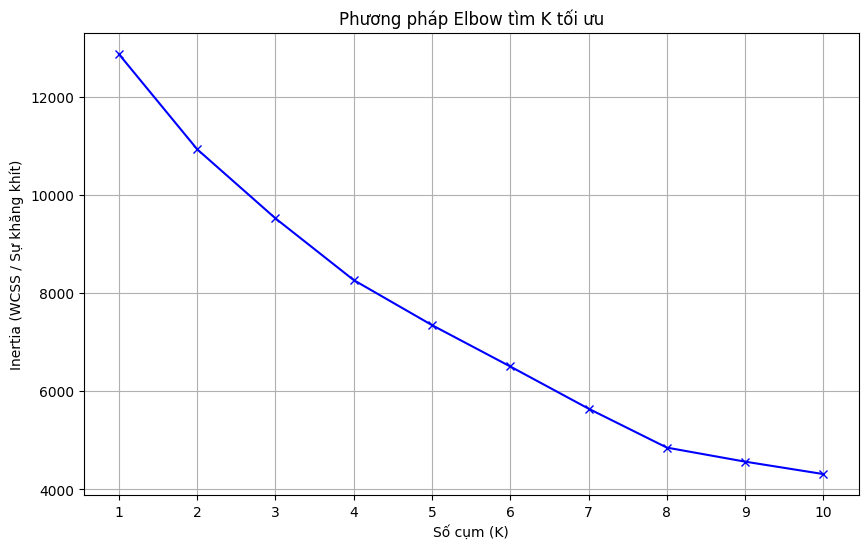


--- CHẠY MÔ HÌNH CUỐI CÙNG ---
Vui lòng nhìn vào đồ thị Elbow vừa hiển thị và quyết định số K tốt nhất.
Đã chọn K = 4. Đang chạy mô hình K-means cuối cùng...

----------- KẾT QUẢ PHÂN CỤM (CHI TIẾT - ĐẦY ĐỦ CỘT) -----------
      RAM  Front Camera  Back Camera  Battery Capacity  Screen Size  \
896   8.0          20.0         64.0             4.700         6.67   
457  16.0          32.0         50.0             5.500         6.78   
461  12.0          16.0         50.0             6.000         6.83   
435   8.0          32.0         48.0             4.025         6.40   
436   8.0          32.0         48.0             4.025         6.40   
..    ...           ...          ...               ...          ...   
45    6.0          12.0         12.0             4.352         6.70   
46    6.0          12.0         12.0             4.352         6.70   
47    6.0          12.0         12.0             4.352         6.70   
48    4.0          12.0         12.0             2.227         5.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import joblib

FILE_PATH = "dataAfterPreprocess.csv"

NUMERIC_FEATURES = [
    'RAM', 'Front Camera', 'Back Camera', 'Battery Capacity', 
    'Screen Size', 'ROM','Launched Price (USA)',
    'Company_Apple', 'Company_Honor', 'Company_Oppo', 'Company_Other', 
    'Company_Samsung', 'Company_Vivo', 'Processor_Avg_Price_Scaled'
]

CATEGORICAL_FEATURES = []
MAX_K_TO_TEST = 10 

print(f"--- Đang tải dữ liệu từ: {FILE_PATH} ---")

try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file tại '{FILE_PATH}'.")
    exit()
except Exception as e:
    print(f"Đã xảy ra lỗi khi đọc file: {e}")
    exit()

print("Tải dữ liệu thành công.")

try:
    df_to_process = df[NUMERIC_FEATURES + CATEGORICAL_FEATURES]
except KeyError:
    print("LỖI: Tên cột trong NUMERIC_FEATURES không khớp với file CSV.")
    exit()

numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, NUMERIC_FEATURES)
    ],
    remainder='passthrough'
)
X_preprocessed = preprocessor.fit_transform(df_to_process)
print("Đã chuẩn hóa các cột đặc trưng.")

preprocessor_filename = "preprocessor.pkl"
joblib.dump(preprocessor, preprocessor_filename)
print(f"Đã lưu cỗ máy chuẩn hóa vào: {preprocessor_filename}")

print(f"\n--- Đang chạy phương pháp Elbow để tìm K (từ 1 đến {MAX_K_TO_TEST})... ---")
inertia_list = []
K_range = range(1, MAX_K_TO_TEST + 1)

for k in K_range:
    kmeans_model = KMeans(n_clusters=k, init='k-means++', n_init=10, random_state=42)
    kmeans_model.fit(X_preprocessed)
    inertia_list.append(kmeans_model.inertia_)

print("Đã xong! Đang hiển thị đồ thị Elbow...")
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia_list, 'bx-')
plt.xlabel('Số cụm (K)')
plt.ylabel('Inertia (WCSS / Sự khăng khít)')
plt.title('Phương pháp Elbow tìm K tối ưu')
plt.grid(True)
plt.xticks(K_range)
plt.show()

print("\n--- CHẠY MÔ HÌNH CUỐI CÙNG ---")
print("Vui lòng nhìn vào đồ thị Elbow vừa hiển thị và quyết định số K tốt nhất.")

while True:
    try:
        BEST_K = int(input(f"Nhập số K bạn chọn (từ 2 đến {MAX_K_TO_TEST}): "))
        if 2 <= BEST_K <= MAX_K_TO_TEST:
            break
        else:
            print(f"Vui lòng nhập một số trong khoảng 2 đến {MAX_K_TO_TEST}.")
    except ValueError:
        print("Vui lòng nhập một con số nguyên.")

print(f"Đã chọn K = {BEST_K}. Đang chạy mô hình K-means cuối cùng...")

final_model = KMeans(
    n_clusters=BEST_K, 
    init='k-means++', 
    n_init=10, 
    random_state=42
)

clusters = final_model.fit_predict(X_preprocessed)
df['Cluster'] = clusters

print("\n----------- KẾT QUẢ PHÂN CỤM (CHI TIẾT - ĐẦY ĐỦ CỘT) -----------")
print(df.sort_values(by='Cluster'))
print("\n")

model_filename = "kmeans_model.pkl"
joblib.dump(final_model, model_filename)
print(f"ĐÃ LƯU MODEL K-MEANS VÀO FILE: {model_filename}")

print(f"--- ĐẶC ĐIỂM TRUNG BÌNH CỦA {BEST_K} CỤM ---")
cluster_summary = df.groupby('Cluster')[NUMERIC_FEATURES].mean()
print(cluster_summary)

print(f"\n--- DÁN NHÃN THỦ CÔNG ---")
print(f"Lần lượt nhập {BEST_K} tên nhãn cho từng cụm (từ 0 đến {BEST_K-1}).")

label_mapping = {}

for k in range(BEST_K):
    label_name = input(f"Nhập tên nhãn (label) cho Cluster {k}: ")
    label_mapping[k] = label_name

print("\nĐã tạo bản đồ nhãn (label mapping) sau:")
print(label_mapping)

df['PhanKhuc'] = df['Cluster'].map(label_mapping)

print("\n----------- KẾT QUẢ SAU KHI DÁN NHÃN -----------")
print("Đây là DataFrame đầy đủ với cột 'PhanKhuc' mới:")
print(df.sort_values(by='Cluster'))


OUTPUT_FILE_PATH = "data_with_clusters_and_labels.csv"
try:
    df.to_csv(OUTPUT_FILE_PATH, index=False, encoding='utf-8')
    print(f"\n✅ ĐÃ LƯU KẾT QUẢ PHÂN KHÚC VÀO FILE: {OUTPUT_FILE_PATH}")
except Exception as e:
    print(f"\n❌ LỖI KHI LƯU FILE CSV: {e}")
# -----------------------------------------------------------------


print("\n----------- TÓM TẮT SỐ LƯỢSNG PHÂN KHÚC -----------")
print(df['PhanKhuc'].value_counts())

print("\n--- KẾT THÚC CHƯƠNG TRÌNH ---")